# `fmri-06`: Functional connectivity
This demo introduces functional connectivity analysis on resting-state data. Resting-state paradigms generally have no external experimental stimulus or behavioral output; however, brain systems will continue to fluctuate over time as we ruminate. Functional connectivity analysis captures correlations between the intrinsic flucutations of different brain areas across time. Due to the lack of external variables, resting-state data are typically limited to functional connectivity analyses; on the other hand, functional connectivity analyses can be applied to non-resting-state data (e.g. recall the ISFC analysis from `fmri-11`). We'll first perform a seed-based connectivity analysis, then use the full functional connectivity matrix to create a functional parcellation of cortex.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### The NKI-Rockland sample
We'll explore functional connectivity analysis on a public resting-state dataset provided by [Nooner et al., 2012](https://doi.org/10.3389/fnins.2012.00152). These data comprise ~10-minute resting-state runs with a rapid TR of 0.645 s.  These data were preprocessed and spatially normalized to the fsaverage5 cortical surface template. We'll begin with one subject. We'll also use an anatomically-defined surface-based cortical parcellation to guide our analysis ([Destrieux et al., 2010](https://doi.org/10.1016/j.neuroimage.2010.06.010)).

In [2]:
# Load NKI-Rockland resting-state dataset
from nilearn import datasets

data_dir = '/Users/snastase/Work/neu502b-2023/nilearn-data'
nki_dataset = datasets.fetch_surf_nki_enhanced(n_subjects=1,
                                               data_dir=data_dir)

# Load the fsaverage5 cortical surface template
fsaverage5 = datasets.fetch_surf_fsaverage()

# Load Destrieux anatomical atlas for fsaverage5
destrieux_atlas = datasets.fetch_atlas_surf_destrieux(data_dir=data_dir)
parcellation = destrieux_atlas['map_left']
labels = destrieux_atlas['labels']

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
# Extract functional data
from nilearn import surface

func_data = surface.load_surf_data(nki_dataset['func_left'][0]).T
print(f"Functional data shape: {func_data.shape}")

Functional data shape: (895, 10242)


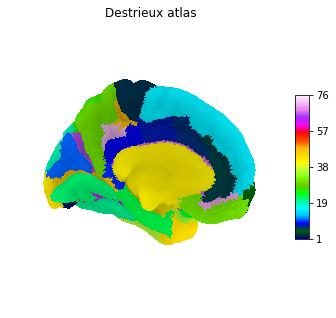

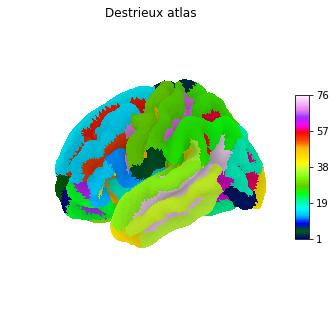

In [4]:
# Plot Destrieux atlas
from nilearn.plotting import plot_surf_roi
plot_surf_roi(fsaverage5['pial_left'], roi_map=parcellation,
                   hemi='left', view='medial', colorbar=True,
                   bg_map=fsaverage5['sulc_left'], bg_on_data=True,
                   darkness=.5, title='Destrieux atlas');

plot_surf_roi(fsaverage5['pial_left'], roi_map=parcellation,
                   hemi='left', view='lateral', colorbar=True,
                   bg_map=fsaverage5['sulc_left'], bg_on_data=True,
                   darkness=.5, title='Destrieux atlas');

### Seed-based functional connectivity
In one of the simplest variations of functional connectivity analysis, we first choose a "seed" region and then compute the correlations between the seed time series and other brain areas. Here we compute the correlation between the average time series from our seed region and all other voxel time series in the cortex. We'll start with the dorsal part of the posterior cingulate—a member of the default-mode network (DMN)—but can try some other seed regions as well.

In [5]:
# Extract seed region via parcellation label
roi_label = b'G_cingul-Post-dorsal'

roi_vertices = np.where(parcellation == labels.index(roi_label))[0]

Plot the ROI on the cortical surface using `plot_surf_roi` and then plot the mean BOLD time series for the ROI.

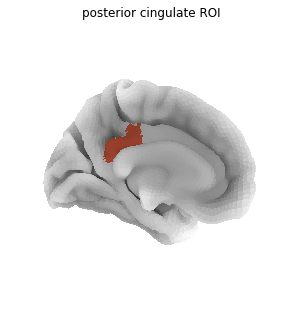

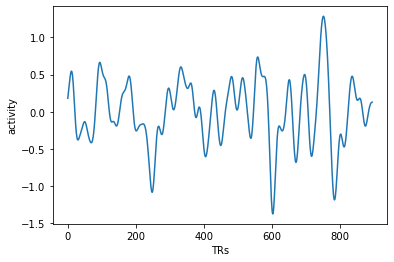

In [6]:
# Transform ROI indices in ROI map
roi_map = np.zeros(parcellation.shape[0], dtype=int)
roi_map[roi_vertices] = 1

# Plot ROI on surface:
plot_surf_roi(fsaverage5['pial_left'], roi_map=roi_map,
              hemi='left', view='medial', cmap='Reds',
              bg_map=fsaverage5['sulc_left'], bg_on_data=True,
              title='posterior cingulate ROI')
plt.show()

# Extract time series from seed region:
func_roi = np.mean(func_data[:, roi_vertices], axis=1)

# Plot seed time series:
plt.plot(func_roi)
plt.xlabel('TRs')
plt.ylabel('activity');

Now that we've extracted the time series for our seed region, we loop through every voxel in the brain and compute the Pearson correlation between time series. This results in a seed-based functional connectivity map for our selected seed region.

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


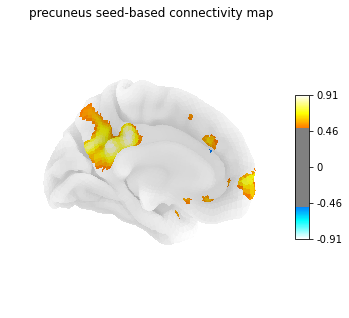

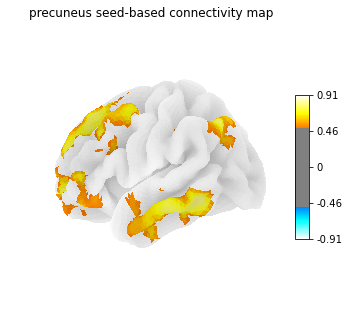

In [7]:
# Compute seed-based functional connectivity map:
from scipy.stats import pearsonr

seed_map = np.zeros(func_data.shape[1])
for v in np.arange(func_data.shape[1]):
    seed_map[v] = pearsonr(func_roi, func_data[:, v])[0]
    
# Plot surface map:
from nilearn.plotting import plot_surf_stat_map

threshold = .5
plot_surf_stat_map(fsaverage5['pial_left'], stat_map=seed_map,
                   hemi='left', view='medial', colorbar=True,
                   bg_map=fsaverage5['sulc_left'], bg_on_data=True,
                   darkness=.4, threshold=threshold,
                   title='precuneus seed-based connectivity map');

plot_surf_stat_map(fsaverage5['pial_left'], stat_map=seed_map,
                   hemi='left', view='lateral', colorbar=True,
                   bg_map=fsaverage5['sulc_left'], bg_on_data=True,
                   darkness=.4, threshold=threshold,
                   title='precuneus seed-based connectivity map');

### Functional connectivity matrices
We can extend the logic of seed-based functional connectivity to every voxel in the brain, yielding a $v\times v$ matrix where $v$ is the number of voxels (or regions) in the brain. We can use `numpy`'s `corrcoef` to compute the full correlation matrix (let's call it `fc_mat`), then reorganize this matrix to reflect the anatomically-defined parcels in our atlas. This captures a certain functional network strucure in the brain. Note that the diagonal of this matrix is not meaningful as it represents the time series at each brain area correlated with itself (i.e. $r = 1$); on the other hand, each row of this matrix corresponds to the seed-based functional connectivity map for the voxel or brain area at that row.

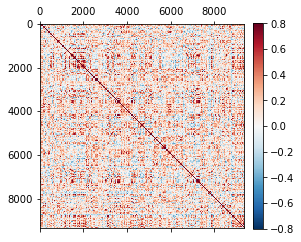

In [8]:
# Compute full correlation matrix:
fc_mat = np.corrcoef(
    
    # Exclude medial wall vertices with all zeros
    func_data[:, ~np.all(func_data == 0, axis=0)].T)

# Sort data by ROI
medial_label = labels.index(b'Medial_wall')
sorter = np.argsort(parcellation[parcellation != medial_label])
fc_sorted = fc_mat[sorter][:, sorter]

# Plot sorted connectivity matrix:
plt.matshow(fc_sorted, cmap='RdBu_r', vmin=-.8, vmax=.8)
plt.colorbar(fraction=0.046, pad=0.04);

Next, we'll load in data for 5 subjects. We'll compute the full functional connectivity matrix for each subject. Note that we can't meaningfully average the time series across subjects because mental events and brain states are happenning at different times across subjects (since there's no shared stimulus driving the brain). However, we *can* average the functional connectivity matrices across subjects.

In [9]:
# Load in a larger sample of subjects
n_subjects = 5

nki_dataset = datasets.fetch_surf_nki_enhanced(n_subjects=n_subjects,
                                               data_dir=data_dir)

In [10]:
# Compute connectome for each subject and average:
fc_subjects = []
for s in np.arange(n_subjects):
    func_data = surface.load_surf_data(nki_dataset['func_left'][s]).T
    fc_mat = np.corrcoef(func_data.T)
    fc_subjects.append(fc_mat)
    print(f"Computed functional connectivity matrix for subject {s}")

fc_mean = np.mean(fc_subjects, axis=0)

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Computed functional connectivity matrix for subject 0
Computed functional connectivity matrix for subject 1
Computed functional connectivity matrix for subject 2
Computed functional connectivity matrix for subject 3
Computed functional connectivity matrix for subject 4


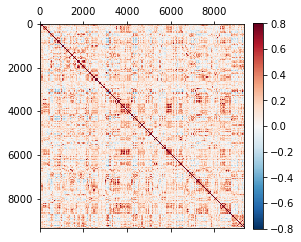

In [11]:
# Remove medial wall:
medial_label = labels.index(b'Medial_wall')
fc_cortex = fc_mean[parcellation != medial_label][:, parcellation != medial_label]

# Sort by anatomical ROIs:
sorter = np.argsort(parcellation[parcellation != medial_label])
fc_sorted = fc_cortex[sorter][:, sorter]

# Plot mean connectivity matrix across subjects:
plt.matshow(fc_sorted, cmap='RdBu_r', vmin=-.8, vmax=.8)
plt.colorbar(fraction=0.046, pad=0.04);

Let's check how reliable the functional network structure is across subjects. We'll vectorize the off-diagonal connectivity values for each subject, then compute the pairwise correlations between the connectivity matrices for all subjects. This yields a $N\times N$ matrix where $N$ is the number of subjects in our sample.

In [12]:
# Check correlation between individual subject FC matrices
from scipy.spatial.distance import squareform

# Vectorize off-diagonal connnectivity values:
fc_condensed = [squareform(fc, checks=False) for fc in fc_subjects]
print("Finished vectorizing connectivity matrices")

# Stack vectorized connectivity matrices:
fc_stack = np.stack(fc_condensed, axis=0)
print("Finished stacking vectorized connectivity matrices")

# Compute correlations between connectomes:
fc_corrs = np.corrcoef(np.nan_to_num(fc_stack))
print("Finished computing correlations across subjects")

Finished vectorizing connectivity matrices
Finished stacking vectorized connectivity matrices
Finished computing correlations across subjects


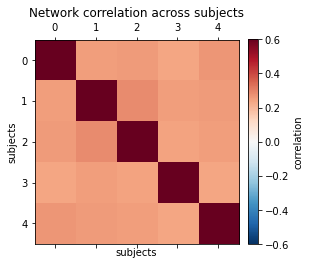

Mean network correlation across subjects: 0.253 (SD: 0.013)


In [13]:
# Plot reliability of network structure across subjects:
plt.matshow(fc_corrs, cmap='RdBu_r', vmin=-.6, vmax=.6)
plt.title("Network correlation across subjects")
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.colorbar(label='correlation', fraction=0.046, pad=0.04)
plt.show()

# Get mean correlation across pairs of subjects:
print("Mean network correlation across subjects: "
      f"{np.mean(squareform(fc_corrs, checks=False)):.3f} "
      f"(SD: {np.std(squareform(fc_corrs, checks=False)):.3f})")

### Functional parcellation
We can use clustering algorithms to "discover" structure in the full connectivity matrices. Use a clustering algorithm (e.g. `AgglomerativeClustering` or `KMeans` from `sklearn`) to cluster the connectivity matrix. For the sake of expediency, pick an arbitrary number of clusters (e.g. `n_clusters=7`). This results in a cluster label for every cortical voxel. This functional parcellation captures some well-known whole-brain networks.

In [14]:
# Cluster functional connectivity:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 7
agg = AgglomerativeClustering(n_clusters=n_clusters,
                              affinity='precomputed',
                              linkage='complete')

agg.fit(1 - np.nan_to_num(fc_cortex))
labels = agg.labels_ + 1

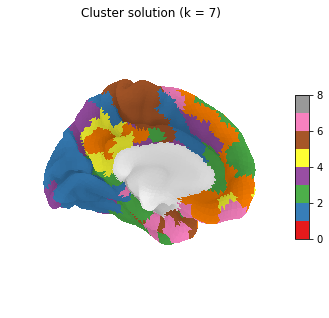

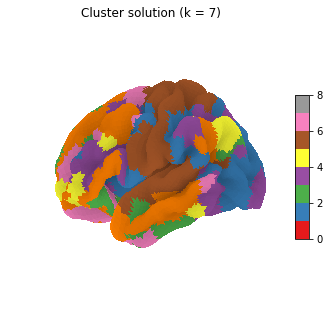

In [15]:
# Reinsert cluster labels into full map:
cluster_map = np.zeros(parcellation.shape)
cluster_map[parcellation != medial_label] = labels

# Plot clusters:
plot_surf_roi(fsaverage5['pial_left'], roi_map=cluster_map,
              hemi='left', view='medial', colorbar=True,
              bg_map=fsaverage5['sulc_left'], bg_on_data=True,
              darkness=.5, cmap='Set1',
              title=f'Cluster solution (k = {n_clusters})');

plot_surf_roi(fsaverage5['pial_left'], roi_map=cluster_map,
              hemi='left', view='lateral', colorbar=True,
              bg_map=fsaverage5['sulc_left'], bg_on_data=True,
              darkness=.5, cmap='Set1',
              title=f'Cluster solution (k = {n_clusters})');

#### References

* Destrieux, C., Fischl, B., Dale, A., & Halgren, E. (2010). Automatic parcellation of human cortical gyri and sulci using standard anatomical nomenclature. *NeuroImage*, *53*(1), 1-15. https://doi.org/10.1016/j.neuroimage.2010.06.010

* Nooner, K. B., Colcombe, S. J., Tobe, R. H., Mennes, M., Benedict, M. M., Moreno, A. L., Panek, L. J., Brown, S., Zavitz, S. T., Li, Q., Sikka, S., Gutman, D., Bangaru, S., Tziona Schlachter, R., Kamiel, S. M., Anwar, A. R., Hinz, C. M., Kaplan, M. S., Rachlin, A. B., Adelsberg, S., Cheung, B., Khanuja, R., Yan, C., Cradddock, R. C., Calhoun, V., Courtney, W., King, M., Wood, D., Cox, C. L., Kelly, A. M. C., Di Martino, A., Petkova, E., Reiss, P. T., Duan, N., Thomsen, D., Biswal, B., Coffey, B., Hoptman, M. J., Javitt, D. C., Pomara, N., Sidtis, J. J., Koplewicz, H. S., Castellanos, F. X., Leventhal, B. L., & Milham, M. (2012). The NKI-Rockland sample: a model for accelerating the pace of discovery science in psychiatry. *Frontiers in Neuroscience*, *6*, 152. https://doi.org/10.3389/fnins.2012.00152